author: leezeeyee   
date: 2021/3/15   
link: [github](https://github.com/easilylazy/pattern-recognition) 

In [3]:
import numpy as np

###
已知两类样本的数据如下： 
 
 
试用Fisher判别函数法，求出最佳投影方向W，及分类阈值y0

思路：
令J(w)最大


### 对数据的理解
首先w1与w2分别为两个类别的数据  
这个例子中，一个数据有两个维度，则需要将这两个维度投影到易分离两个类别的新空间   
通过fisher算法，可以表征类间差别和类内相似，进而找到最佳投影方向！

In [37]:
def loadData():
    w1=[(5,37),(7,30),(10,35),(11.5,40),(14,38),(12,31)]
    w2=[(35,21.5),(39,21.7),(34,16),(37,17)]
    w1=np.asarray(w1)
    w2=np.asarray(w2)
    return w1,w2

In [38]:
w1,w2=loadData()

由于每一行数据是单个数据结果，不利于应用平均函数
我们可以利用numpy的swapaxes交换行列，在只有两维时等价于
``` python
X0=w1[:,0]
X1=w1[:,1]

```

In [7]:
X1=np.swapaxes(w1,0,1)
X2=np.swapaxes(w2,0,1)

计算交换行列后的平均数，其实利用numpy的函数也可以轻松计算得出按列求平均的结果，即`axis=0`

In [8]:
# compute mean for each row
print(X1.mean(axis=1))
Miu1=X1.mean(axis=1)
Miu2=X2.mean(axis=1)
print(Miu1)
print(Miu2)

[ 9.91666667 35.16666667]
[ 9.91666667 35.16666667]
[36.25 19.05]


In [9]:
# 看一下原始数据减去平均值的结果，numpy就是正常的矩阵减法：原数据的每一行都减去平均值，符合需要
w1-Miu1

array([[-4.91666667,  1.83333333],
       [-2.91666667, -5.16666667],
       [ 0.08333333, -0.16666667],
       [ 1.58333333,  4.83333333],
       [ 4.08333333,  2.83333333],
       [ 2.08333333, -4.16666667]])

### 协方差covariance
使用numpy内置函数cov()与ppt上的公式计算结果不同，因为标准的协方差公式为  
$$cov=\frac{1}{n-1} lazyCov$$
$$lazyCov=(X-\mu)(X-\mu)^{T}$$

In [10]:
def lazyCov(X,miu):
    return np.dot(np.transpose(X-miu),X-miu)

In [11]:
Sigma1=lazyCov(w1,Miu1)
Sigma2=lazyCov(w2,Miu2)

In [12]:
print(Sigma1)
print(Sigma2)

[[56.20833333 16.58333333]
 [16.58333333 78.83333333]]
[[14.75  9.55]
 [ 9.55 26.53]]


In [13]:
lazyCov(w1,Miu1)/5

array([[11.24166667,  3.31666667],
       [ 3.31666667, 15.76666667]])

In [14]:
Sigma2

array([[14.75,  9.55],
       [ 9.55, 26.53]])

### 类间差别与类内相似

In [15]:
Sb=np.dot(Miu1-Miu2,np.transpose(Miu1-Miu2))
print(Sb)

953.1913888888889


In [16]:
Sb=np.dot(np.transpose(Miu1-Miu2).reshape(2,1),(Miu1-Miu2).reshape(1,2))
print(Sb)
print(Miu1-Miu2)
print(np.transpose(Miu1-Miu2).shape)

[[ 693.44444444 -424.40555556]
 [-424.40555556  259.74694444]]
[-26.33333333  16.11666667]
(2,)


In [17]:
Sw=Sigma1+Sigma2
print(Sw)

[[ 70.95833333  26.13333333]
 [ 26.13333333 105.36333333]]


### 经过一系列推导，可知最佳的projection$w*$由下面的公式决定：
$$w*=(\sigma_{1}+\sigma_{2})^{-1}(\mu_{1}-\mu_{2})$$

In [18]:
projectionW=np.dot((Miu1-Miu2).reshape(1,2),np.linalg.inv(Sigma1+Sigma2))
print(projectionW)

[[-0.47041598  0.26964033]]


In [19]:
Zt=np.dot(projectionW,(Miu1+Miu2).transpose())/2
print(Zt)

[-3.54926888]


In [20]:
Z1=np.dot(projectionW,w1.transpose())
Z2=np.dot(projectionW,w2.transpose())

### 检验分类结果，全部区分开来

In [21]:
print(Z1[Z1>Zt])
print(Z1[Z1<Zt])
print(Z2[Z2>Zt])
print(Z2[Z2<Zt])

[7.62461243 4.79629813 4.73325185 5.37582954 3.66050892 2.71385855]
[]
[]
[-10.6672922  -12.49502806 -11.67989805 -12.82150566]


### fisher
将上面的集成为fisher函数

In [98]:
def fisher(X,y):

    w1=X[y>0]
    w2=X[y<0]
    Miu1=w1.mean(axis=0)
    Miu2=w2.mean(axis=0)
    Sigma1=lazyCov(w1,Miu1)
    Sigma2=lazyCov(w2,Miu2)
    projectionW=np.dot(np.linalg.inv(Sigma1+Sigma2),(Miu1-Miu2).reshape(2,1))
    Zt=np.dot(projectionW.transpose(),(Miu1+Miu2))/2
    return projectionW,Zt


## TEST

In [133]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
class Point():
    def __init__(self,x,y):
        self.x=x
        self.y=y
def live_plot(X,y,W,bias,lims=(9,9),scale=2,clear=True,title=""):
    '''
    清空输出框并绘制二维分类图像
    Args:
        X(numpy.ndarray):分类数据集
        y(numpy.ndarray):分类标签 
        W(numpy.ndarray):分界面法向量
        lims(tuple):lims[0]为x方向的长度，类似lims[1]为y方向
        scale(int):分类面（直线）尺度放缩
        bias(bool):True 含偏置向量，则取后两位绘图
        clear(bool):True,清空输出框
    '''
    if clear:
            clear_output(wait=True)
    plt.figure(figsize=(7,5))
    if bias:
        try:
            W=W.reshape(3)
            k=-W[1]/W[2]
            b=-W[0]/W[2]
        except Exception as e:
            traceback.print_exc()
    else:
        try:
            W=W.reshape(2)
            k=-W[0]/W[1]
            b=0
        except Exception as e:
            traceback.print_exc()
    P1=Point(scale,k*scale+b)
    P2=Point(-scale,-k*scale+b)
    plt.scatter(X[:,0],X[:,1],c=y.transpose(),marker = 'o', s=20, cmap = plt.cm.Spectral)
    plt.plot([P1.x,P2.x],[P1.y,P2.y],'-')
    plt.xlim((-lims[0], lims[0]))
    plt.ylim((-lims[1], lims[1]))
    plt.title(title)
    plt.legend(["separate line","data point"])
    plt.grid(True)
    plt.show()

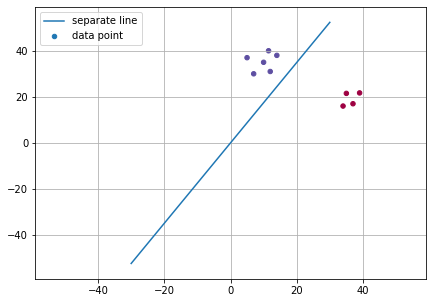

In [134]:
w1,w2=loadData()
X=np.row_stack((w1,w2))
y=np.append(np.ones(w1.shape[0]),-np.ones(w2.shape[0]))
W,Zt=fisher(X,y)
live_plot(X,y,W,bias=False,lims=(59,59),scale=30,clear=False,title="")

In [135]:
def GenerateData(mu,d,N):
    '''
    根据传入参数mu，d，N生成 N 个二维向量的数据集s0 和s1
    Args:
        mu:均值
        d(int):每个数据维度
        N(int):每个分类有N条数据
    Returns:
        X(numpy.ndarray):维度为[N*2,d],前N行为一类，后N行为另一类
        y(numpy.ndarray):维度为[N*2]，标注数据的类别
    '''
    I=np.eye(d)
    mu0=np.array([mu,0])
    mu1=np.array([-mu,0])

    s0=np.random.multivariate_normal(mu0,I,N)
    s1=np.random.multivariate_normal(mu1,I,N)
    X=np.zeros([2*N,d])
    X[:N]=s0
    X[N:]=s1
    y=np.zeros(2*N)
    y[:N]=1
    y[N:]=-1
    return X,y

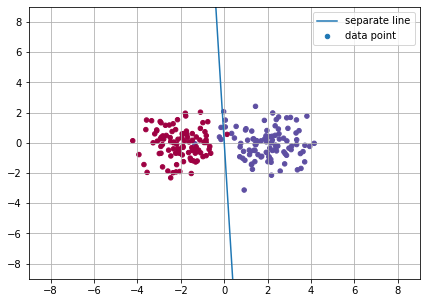

[-0.00104207]


In [136]:
X,y=GenerateData(2,2,100)
W,Zt=fisher(X,y)
live_plot(X,y,W,bias=False,lims=(9,9),scale=30,clear=False,title="")
print(Zt)

In [137]:
def labelErr(X,y,W,Zt):
    '''
    根据阈值Zt与投影面法向量W进行错误值的评价
    '''
    labelY=np.array(y)
    label={}
    Z=np.dot(X,W).reshape(y.shape)
    labelY[np.where((Z>Zt)&(y<0))]=2
    labelY[np.where((Z<Zt)&(y>0))]=-2
    label['wrong-1']=sum(labelY==-2)
    label['right-1']=sum(labelY==-1)
    label['right1']=sum(labelY==1)
    label['wrong1']=sum(labelY==2)
    return labelY,label

{'wrong-1': 33, 'right-1': 162, 'right1': 167, 'wrong1': 38}


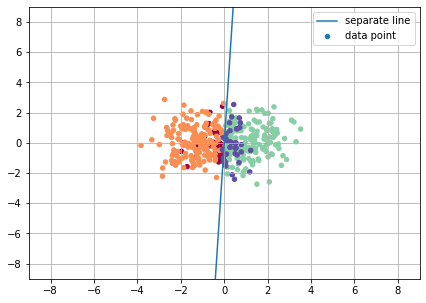

In [138]:
X,y=GenerateData(1,2,200)
# w1,w2=loadData()
# X=np.row_stack((w1,w2))
# y=np.append(np.ones(w1.shape[0]),-np.ones(w2.shape[0]))
W,Zt=fisher(X,y)
labelY,label=labelErr(X,y,W,Zt)
print(label)
live_plot(X,labelY,W,bias=False,lims=(9,9),scale=30,clear=False,title="")
